## Case Study - Churn Prediction

A ride-sharing company (Company X) is interested in predicting rider retention.
To help explore this question, we have provided a sample dataset of a cohort of
users who signed up for an account in January 2014. The data was pulled on July
1, 2014; we consider a user retained if they were “active” (i.e. took a trip)
in the preceding 30 days (from the day the data was pulled). In other words, a
user is "active" if they have taken a trip since June 1, 2014. The data,
`churn.csv`, is in the [data](data) folder.  The data are split into train and
test sets.  You are encouraged to tune and estimate your model's performance on
the train set, then see how it does on the unseen data in the test set at the
end.

We would like you to use this data set to help understand **what factors are
the best predictors for retention**, and offer suggestions to help Company X. 
Therefore, your task is not only to build a
model that minimizes error, but also a model that allows you to interpret the
factors that contributed to your predictions.

Here is a detailed description of the data:

- `city`: city this user signed up in phone: primary device for this user
- `signup_date`: date of account registration; in the form `YYYYMMDD`
- `last_trip_date`: the last time this user completed a trip; in the form `YYYYMMDD`
- `avg_dist`: the average distance (in miles) per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips 
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips 
- `surge_pct`: the percent of trips taken with surge multiplier > 1 
- `avg_surge`: The average surge multiplier over all of this user’s trips 
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up 
- `luxury_car_user`: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise 
- `weekday_pct`: the percent of the user’s trips occurring during a weekday


## Work Flow

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the
provided data for this analysis.
   
2. Build a predictive model to help determine the probability that a rider will
be retained.

3. Evaluate the model.  Focus on metrics that are important for your *statistical
model*.
 
4. Identify / interpret features that are the most influential in affecting
your predictions.

5. Discuss the validity of your model. Issues such as
leakage.  For more on leakage, see [this essay on
Kaggle](https://www.kaggle.com/dansbecker/data-leakage), and this paper: [Leakage in Data
Mining: Formulation, Detection, and Avoidance](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.365.7769&rep=rep1&type=pdf).

6. Repeat 2 - 5 until you have a satisfactory model.

7. Consider business decisions that your model may indicate are appropriate.
Evaluate possible decisions with metrics that are appropriate for *decision
rules*.
   
## Deliverables

- Code you used to build the model.  The more repeatable, self explanatory, the
  better.

- A presentation including the following points:
  - How did you compute the target?
  - What model did you use in the end? Why?
  - Alternative models you considered? Why are they not good enough?
  - What performance metric did you use to evaluate the *model*? Why?
  - **Based on insights from the model, what plans do you propose to
    reduce churn?**
  - What are the potential impacts of implementing these plans or decisions?
    What performance metrics did you use to evaluate these *decisions*, why?


In [46]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from src.helper import clean_churn_data

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
data = pd.read_csv('data/churn_train.csv')
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [49]:
# Clean data using helper function
data_clean = clean_churn_data(data)
data_clean.head()

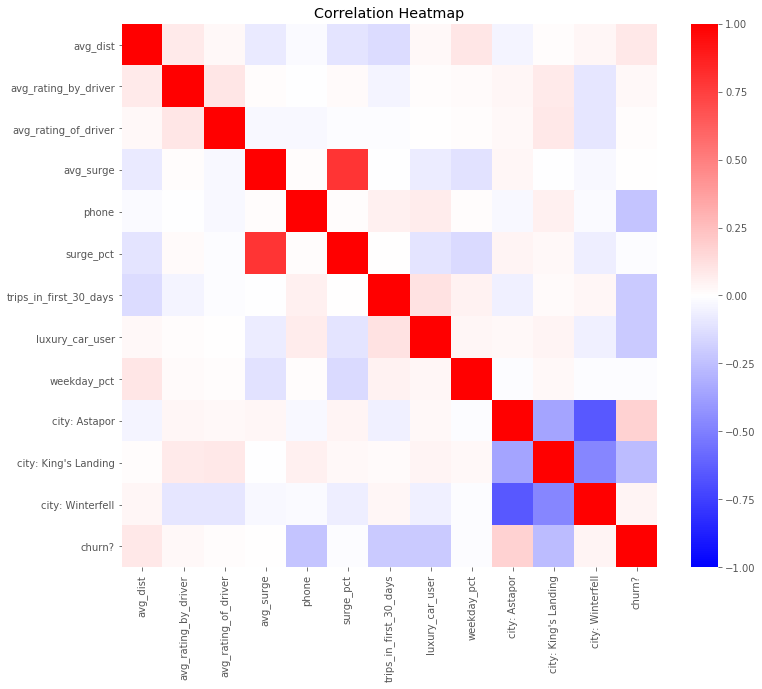

In [51]:
# Make heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data_clean.corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.savefig('corr_heatmap.png', bbox_inches='tight', dpi=350)

In [15]:
data_clean.columns

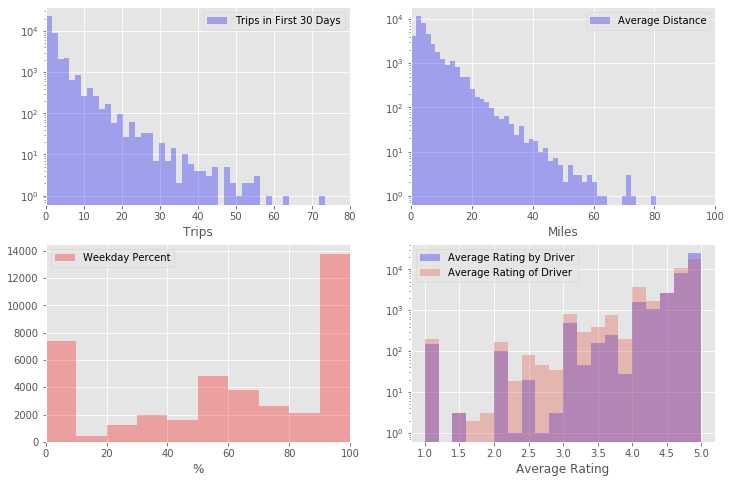

In [17]:
# Plot histograms of some key features
fig, axes = plt.subplots(2,2,figsize=(12,8))

ax = axes[1,1]
ax.hist(data_clean['avg_rating_by_driver'], alpha=0.3, bins=20, log=True, color='blue',
        label='Average Rating by Driver')
ax.hist(data_clean['avg_rating_of_driver'], alpha=0.3, bins=20, log=True,
        label='Average Rating of Driver')
ax.set_xlabel('Average Rating')
ax.legend()

ax = axes[0,0]
ax.hist(data_clean['trips_in_first_30_days'], alpha=0.3, bins=80, log=True, 
        color='blue', label='Trips in First 30 Days')
ax.set_xlim(0,80)
ax.set_xlabel('Trips')
ax.legend()

ax = axes[0,1]
ax.hist(data_clean['avg_dist'], alpha=0.3, bins=100, log=True, 
        color='blue', label='Average Distance')
ax.set_xlim(0,100)
ax.set_xlabel('Miles')
ax.legend()

ax = axes[1,0]
ax.hist(data_clean['weekday_pct'], alpha=0.3, bins=10, label='Weekday Percent', color='red')
ax.set_xlim(0,100)
ax.set_xlabel('%')
ax.legend()

plt.savefig('histograms_of_features.png', dpi=350)

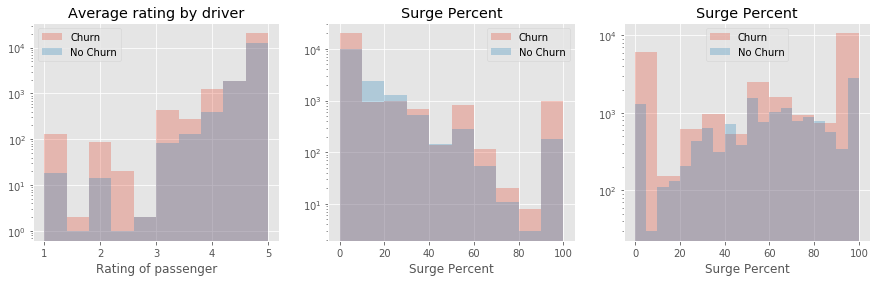

In [323]:
# Look into average rating by driver, surge percent, weekday percent, kings landing
data_churn = data_clean[data_clean['churn?'] == 1]
data_nochurn = data_clean[data_clean['churn?'] == 0]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
ax=axes[0]
ax.hist(data_churn['avg_rating_by_driver'], log=True, alpha=0.3, label='Churn')
ax.hist(data_nochurn['avg_rating_by_driver'], log=True, alpha=0.3, label='No Churn')
ax.legend()
ax.set_title('Average rating by driver')
ax.set_xlabel('Rating of passenger')
plt.savefig('avg_rating_churn.png', dpi=350)

ax=axes[1]
ax.hist(data_churn['surge_pct'], log=True, alpha=0.3, label='Churn')
ax.hist(data_nochurn['surge_pct'], log=True, alpha=0.3, label='No Churn')
ax.legend()
ax.set_title('Surge Percent')
ax.set_xlabel('Surge Percent')
plt.savefig('avg_churn.png', dpi=350)

ax=axes[2]
ax.hist(data_churn['weekday_pct'], log=True, alpha=0.3, bins=10,label='Churn')
ax.hist(data_nochurn['weekday_pct'], log=True, alpha=0.3, bins=20, label='No Churn')
ax.legend()
ax.set_title('Surge Percent')
ax.set_xlabel('Surge Percent')
plt.savefig('avg_churn.png', dpi=350)


## Gradient Boosting Classifier

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve
from sklearn.pipeline import make_pipeline
from src.helper import accuracy_scores, plot_roc_curve

from sklearn.ensemble import GradientBoostingClassifier

In [39]:
# Create a copy of data for making models
df_copy = data_clean.copy()
y = df_copy.pop('churn?').values
X = df_copy.values

In [40]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, X_test.shape

((29760, 12), (9921, 12))

In [42]:
# Make model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
mean_squared_error(y_test, y_hat)

0.2174175990323556

In [44]:
accuracy_scores(y_test, y_hat)

(0.783,
 0.859,
 0.809,
 0.217,
                  Predicted Negative  Predicted Positive
 Actual Negative                2379                1274
 Actual Positive                 883                5385)

Out of box scores: Accuracy is 0.79, Precision is 0.87, Recall is 0.81, and MSE is 0.213

## Optimization of parameters

Let's try modifying learning rate, max depth, n-estimators

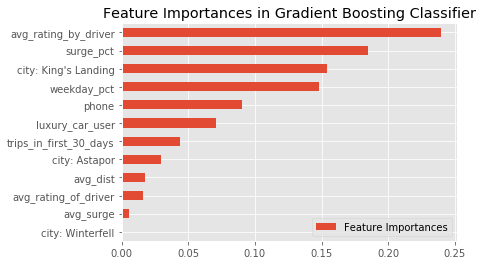

In [52]:
# Feature Importances
importances = pd.DataFrame({'Feature Importances': model.feature_importances_}, 
                       index=df_copy.columns)

importances = importances.sort_values(by='Feature Importances')
importances.plot(kind='barh')
plt.title("Feature Importances in Gradient Boosting Classifier")
plt.savefig("feature_import.png", bbox_inches='tight', dpi=350)

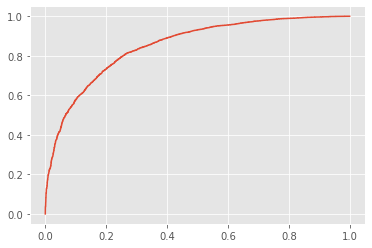

In [53]:
# ROC curve -> arguments are y_true and probabilities of predictions on X_test
proba = model.predict_proba(X_test)
model.classes_ # This tells us that class [0] = 0 and class[1] = 1
proba_true = proba[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba_true)
plt.plot(fpr, tpr)

In [ ]:
plot_roc_curve(proba_true, y_test)

array([1.98124917, 0.98124917, 0.9774402 , ..., 0.03268003, 0.03258577,
       0.03031829])

## Tuning Parameters

In [216]:
# First look at n_estimators
n = 3000
model = GradientBoostingClassifier(n_estimators=n)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

train_score = np.zeros(n)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(n)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)


137

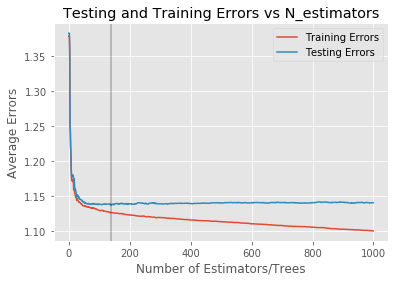

In [228]:
fig, ax = plt.subplots()
ax.plot(train_score[:1000], label="Training Errors")
ax.plot(test_score[:1000], label="Testing Errors")
ax.set_xlabel("Number of Estimators/Trees")
ax.set_ylabel("Average Errors")
ax.legend()
ax.set_title("Testing and Training Errors vs N_estimators")
ax.axvline(x=137, color='black', linewidth=0.4)
plt.savefig("test_train_errors.png", dpi=350)

np.argmin(test_score)

It looks like the minimum occurs at n_estimators = 137 trees

In [271]:
# Now look at learning rate and plot ROC curve for each
lr = [0.01, 0.05, 0.1, 0.5, 1]
models = [GradientBoostingClassifier(learning_rate=l, n_estimators=500) for l in lr]
models

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.01, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=500,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.05, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impuri

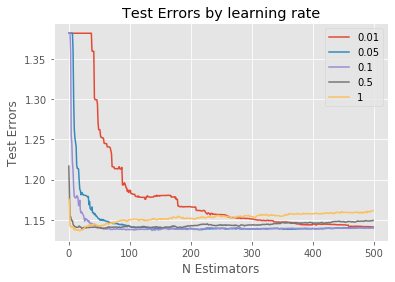

In [275]:
for l, m in zip(lr, models):
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    accuracy, precision, recall, mse = accuracy_scores(y_test, y_pred)
    
    train_score = np.zeros(500)
    for i, y_pred in enumerate(m.staged_predict(X_train)):
        train_score[i] = m.loss_(y_train, y_pred)

    test_score = np.zeros(500)
    for i, y_pred in enumerate(m.staged_predict(X_test)):
        test_score[i] = m.loss_(y_test, y_pred)

  #  plt.plot(train_score)
    plt.plot(test_score, label=l)
    plt.title("Test Errors by learning rate")
    plt.xlabel("N Estimators")
    plt.ylabel("Test Errors")    
    plt.legend()
    plt.savefig('lr_errors.png', dpi=250)

In [291]:
# Run on true test data
data_test = pd.read_csv('data/churn_test.csv')
dt_clean = clean_churn_data(data_test)
yt = dt_clean.pop('churn?').values
Xt = dt_clean.values
yt.shape, Xt.shape

((9923,), (9923, 12))

In [289]:
model_opt = GradientBoostingClassifier(n_estimators=137)
model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(Xt)
accuracy_scores(yt, y_pred)

(0.782, 0.862, 0.803, 0.218)

In [295]:
Xt.shape, yt.shape
plot_roc_curve(model_opt, 'l', Xt, yt)

ValueError: Found input variables with inconsistent numbers of samples: [9923, 9921]

In [280]:
def param_search(lr=0.1, n=100, md=3):

    model = GradientBoostingClassifier(learning_rate=lr, n_estimators=n, max_depth=md)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred

# def plot_roc_curve(model, label, X_test, y_test):
#     proba = model.predict_proba(X_test)
#     fpr, tpr, thresholds = roc_curve(y_test, proba_true)
#     plt.plot(fpr, tpr)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curve")
#     plt.legend()
#     plt.savefig("roc.png", dpi=350)

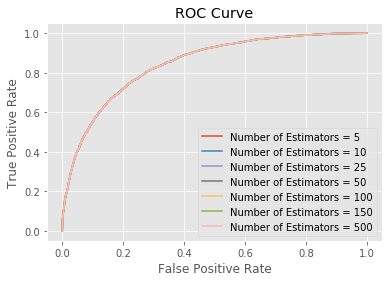

<Figure size 432x288 with 0 Axes>

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def plot_roc_curve(probabilities, labels, ax, title):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''
    probabilities = probabilities.reshape(labels.shape)
    thresholds = np.linspace(0.01, 0.99, 100)
    tpr = []
    fpr = []
    
    num_true_pos = np.sum(labels)
    num_false_pos = len(labels) - num_true_pos
    
    for t in thresholds:
        num_correct_pred = np.sum((probabilities >= t) & (labels == 1))
        num_incorrect_pred = np.sum((probabilities >= t) & (labels == 0))
        
        tpr.append(num_correct_pred / num_true_pos)
        fpr.append(num_incorrect_pred / num_false_pos)
        
    mean_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, 'b', label='ROC (area = %2.2f)' % mean_auc, lw=2)
    ax.set_xlabel('False Positive Rate', fontsize=20)
    ax.set_ylabel('True Positive Rate', fontsize=20)
    ax.set_title('Receiver Operating Characteristic: %s' % title, fontsize=20)
    ax.legend(loc="lower right", fontsize=15)
    ax.plot(thresholds, thresholds, color='k', ls='--', alpha=.5)
        
    return ax, tpr, fpr, thresholds


ValueError: cannot reshape array of size 19846 into shape (9923,)

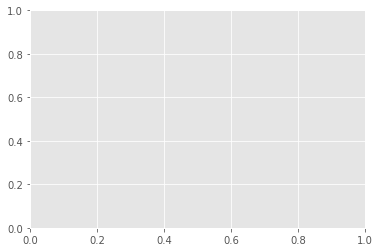

In [327]:
proba = model_opt.predict_proba(Xt)
fig, ax = plt.subplots()
#plot_roc_curve(proba, yt, ax, 'test')